In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
path

Path('/home/ilua/.fastai/data/mnist_sample')

In [4]:
Path.BASE_PATH = path

In [5]:
for filename in os.listdir(path):
    file_path = path / filename
    if os.path.isfile(file_path):
        print(file_path)

/home/ilua/.fastai/data/mnist_sample/labels.csv


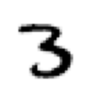

In [6]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [7]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [8]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [9]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [10]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [11]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [12]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [13]:
apply_kernel(5,7,top_edge)

tensor(762.)

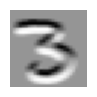

In [14]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

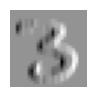

In [15]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

### Convolutions in PyTorch

In [16]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [17]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [18]:
yb

TensorCategory([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                1, 1, 1], device='cuda:0')

In [17]:
df = pd.DataFrame(xb[11].squeeze(0))
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090196,0.494118,0.035294,0.000000,0.188235,0.572549,0.972549,1.000000,0.835294,0.152941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592157,0.992157,0.462745,0.686275,0.894118,0.992157,0.992157,0.992157,0.992157,0.964706,0.231373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145098,0.937255,0.992157,0.992157,0.992157,0.988235,0.972549,0.572549,0.545098,0.909804,0.992157,0.686275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [19]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [20]:
edge_kernels = edge_kernels.unsqueeze(1)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

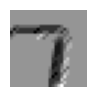

In [21]:
show_image(batch_features[61,2]);

In [22]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [23]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [24]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [25]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [26]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [27]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [28]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [29]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.066450,0.024251,0.992149,00:02
1,0.017513,0.016167,0.993131,00:02


In [30]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [31]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

### Color images

In [32]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

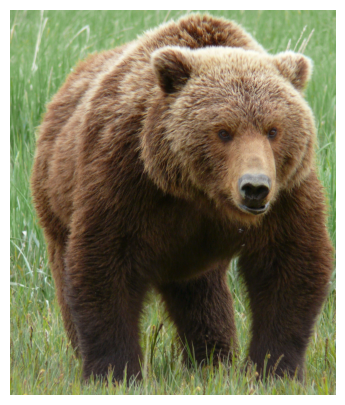

In [33]:
show_image(im);

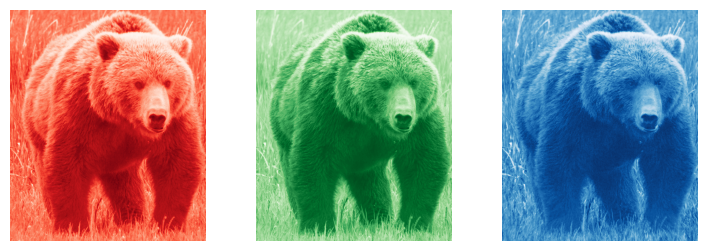

In [34]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

In [35]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [36]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [37]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

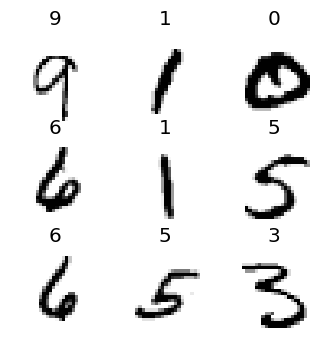

In [38]:
dls.show_batch(max_n=9, figsize=(4,4))

In [67]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [62]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [63]:
from fastai.callback.hook import *

In [64]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [68]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.307145,2.309577,0.113500,00:12


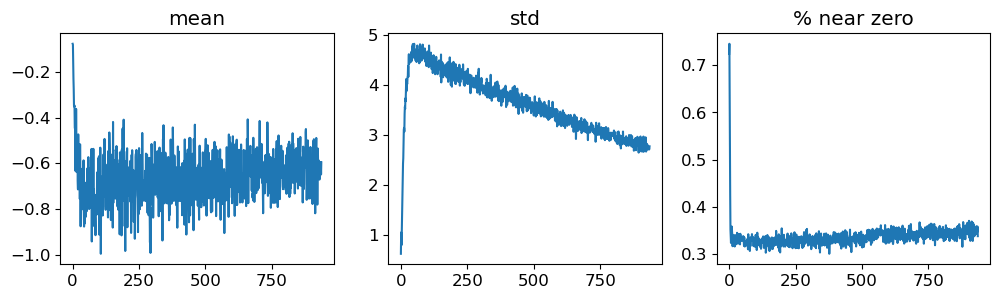

In [69]:
learn.activation_stats.plot_layer_stats(0)

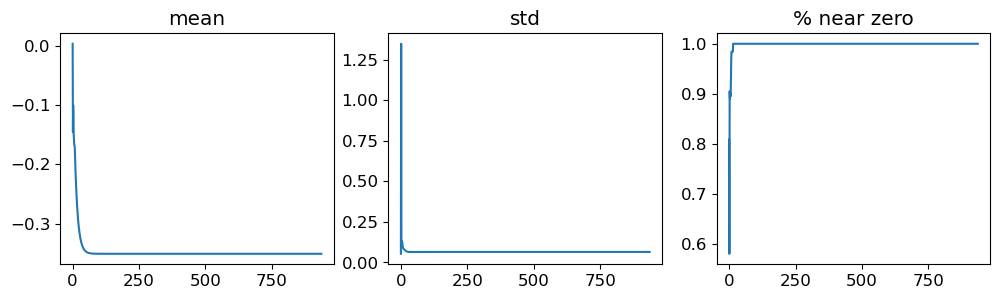

In [49]:
learn.activation_stats.plot_layer_stats(-2)

In [73]:
dls = get_dls(512)

In [74]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.577718,0.340170,0.891900,00:05


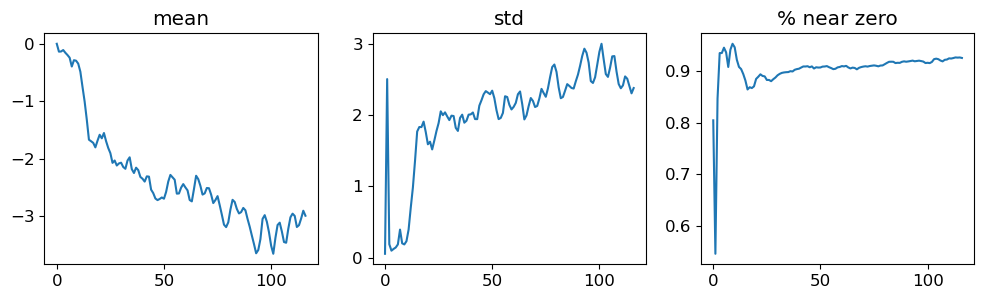

In [75]:
learn.activation_stats.plot_layer_stats(-2)

In [76]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [77]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.204452,0.070696,0.977300,00:05


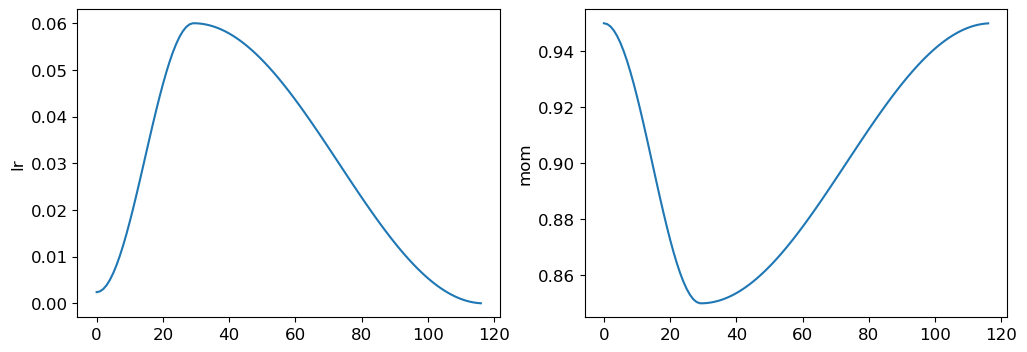

In [55]:
learn.recorder.plot_sched()

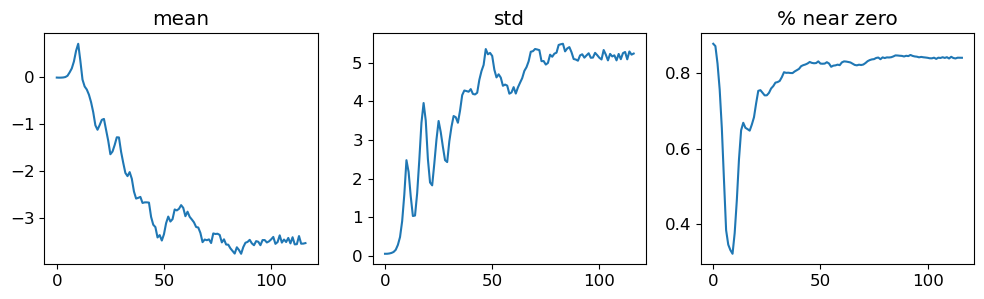

In [56]:
learn.activation_stats.plot_layer_stats(-2)

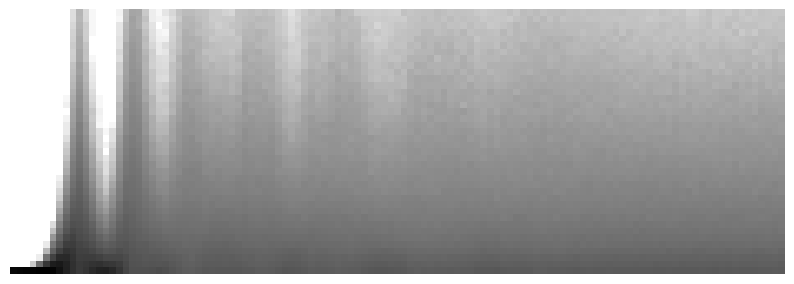

In [78]:
learn.activation_stats.color_dim(-2)

### ADDING BATCH NORMALIZATION

In [79]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)


In [80]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.140699,0.065149,0.983500,00:06


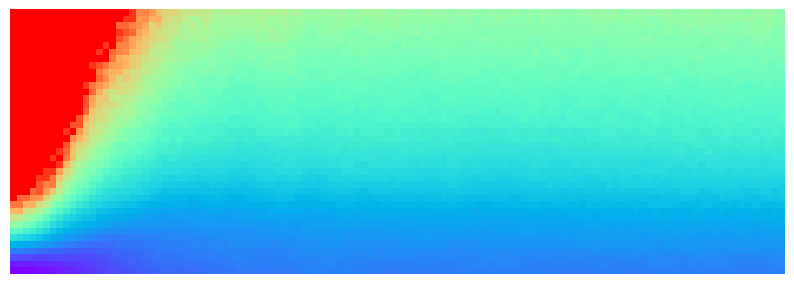

In [81]:
matplotlib.rcParams['image.cmap'] = 'rainbow_r'
learn.activation_stats.color_dim(-4)

In [82]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.186565,0.074560,0.976300,00:06
1,0.080086,0.089574,0.974600,00:06
2,0.050612,0.057238,0.982000,00:06
3,0.031541,0.030403,0.989800,00:06
4,0.015811,0.023553,0.993300,00:06


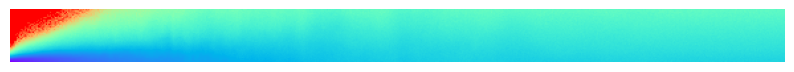

In [83]:
learn.activation_stats.color_dim(-4)

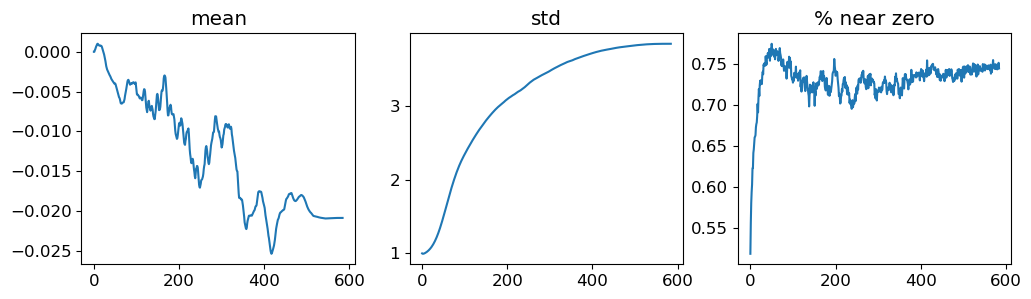

In [84]:
learn.activation_stats.plot_layer_stats(-1)

### ADDING LAYER NORMALIZATION

In [91]:
def simple_cnn_lnorm():
    return sequential(
        conv_base(1 ,8, ks=5),        #14x14
        nn.LayerNorm([ 8, 14, 14]),
        conv_base(8 ,16),             #7x7
        nn.LayerNorm([ 16, 7, 7]),
        conv_base(16,32),             #4x4
        nn.LayerNorm([ 32, 4, 4]),
        conv_base(32,64),             #2x2
        nn.LayerNorm([ 64, 2, 2]),
        conv_base(64,10, act=False),  #1x1
        nn.LayerNorm([ 10, 1, 1]),
        Flatten(),
    )

In [86]:
def conv_base(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    # layers.append(nn.LayerNorm([nf,]))
    return nn.Sequential(*layers)

In [92]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn_lnorm(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [93]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.145452,0.061782,0.983600,00:06


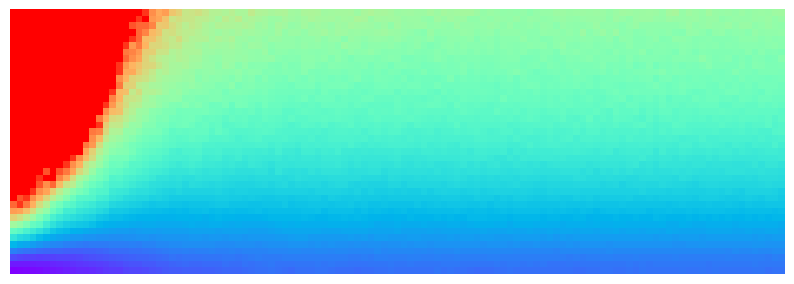

In [94]:
learn.activation_stats.color_dim(-4)

In [95]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.212252,0.109731,0.969000,00:06
1,0.100140,0.055681,0.983700,00:06
2,0.061827,0.057208,0.981700,00:07
3,0.038713,0.038001,0.988000,00:08
4,0.018164,0.032361,0.989600,00:08


Layer normalization working worse then batch one. And it has longer divergence times

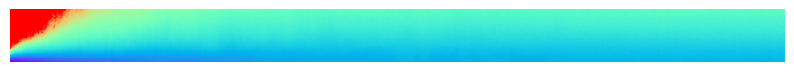

In [96]:
learn.activation_stats.color_dim(-4)

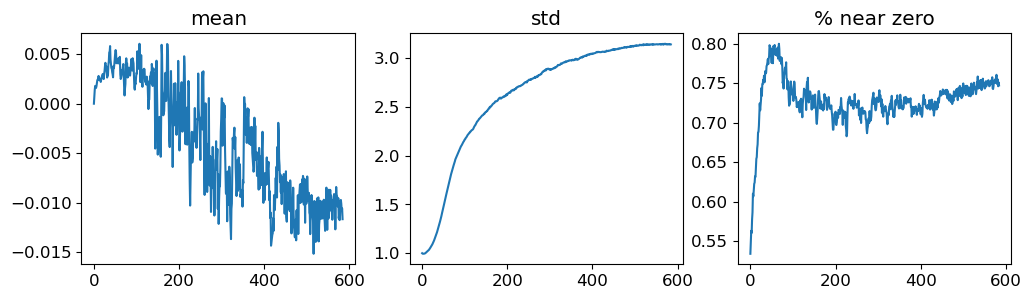

In [97]:
learn.activation_stats.plot_layer_stats(-1)

Mean is more volative here too

### ADDING Instance Normalization

In [182]:
instance_norm = nn.InstanceNorm2d(8, affine=True)
def simple_cnn_Instnorm():
    return sequential(
        conv_InstNorm(1 ,8, ks=5),        #14x14
        conv_InstNorm(8 ,16),             #7x7
        conv_InstNorm(16,32),             #4x4
        conv_InstNorm(32,64),             #2x2
        conv_InstNorm(64,10, act=False),  #1x1
        Flatten(),
    )

In [181]:
def conv_InstNorm(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    if act:
        layers.append(nn.InstanceNorm2d(nf, affine=True))
    return nn.Sequential(*layers)

In [183]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn_Instnorm(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

Init signature:
nn.InstanceNorm2d(
    num_features: int,
    eps: float = 1e-05,
    momentum: float = 0.1,
    affine: bool = False,
    track_running_stats: bool = False,
    device=None,
    dtype=None,
) -> None
Source:        
class InstanceNorm2d(_InstanceNorm):
    r"""Applies Instance Normalization.

    This operation applies Instance Normalization
    over a 4D input (a mini-batch of 2D inputs
    with additional channel dimension) as described in the paper
    `Instance Normalization: The Missing Ingredient for Fast Stylization
    <https://arxiv.org/abs/1607.08022>`__.

    .. math::

        y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

    The mean and standard-deviation are calculated per-dimension separately
    for each object in a mini-batch. :math:`\gamma` and :math:`\beta` are learnable parameter vectors
    of size `C` (where `C` is the input size) if :attr:`affine` is ``True``.
    The standard-deviation is calculated via the 

In [175]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.243413,0.130384,0.960000,00:06


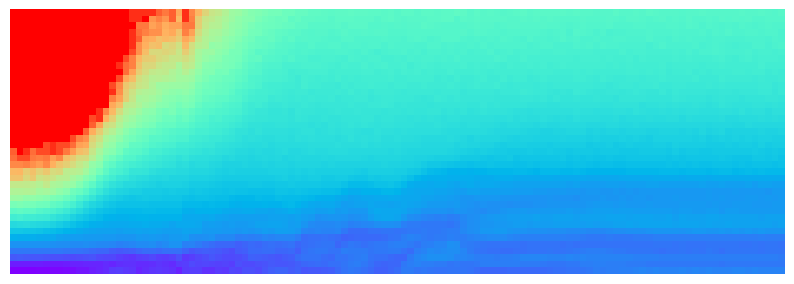

In [176]:
learn.activation_stats.color_dim(-4)

In [184]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.260432,0.140448,0.956000,00:06
1,0.154672,0.104687,0.967200,00:06
2,0.099735,0.062511,0.979600,00:06
3,0.060854,0.046830,0.985000,00:06
4,0.040009,0.045345,0.983500,00:06


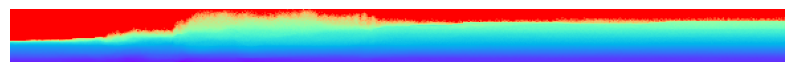

In [185]:
learn.activation_stats.color_dim(-4)

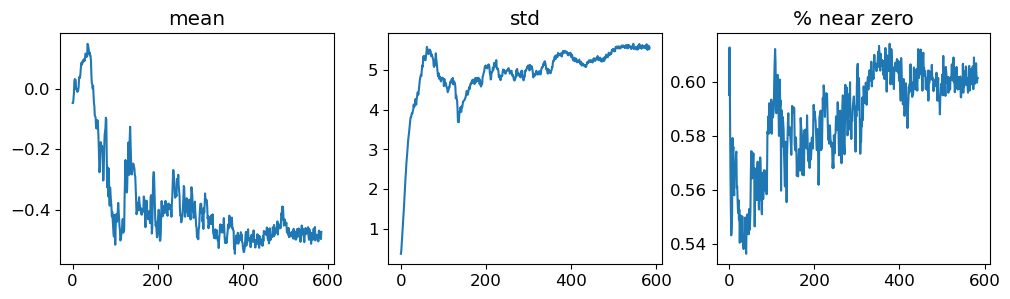

In [186]:
learn.activation_stats.plot_layer_stats(-1)

###  moving the activation function after the batch normalization

In [187]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [188]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [192]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)


In [193]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.137951,0.060575,0.985300,00:06


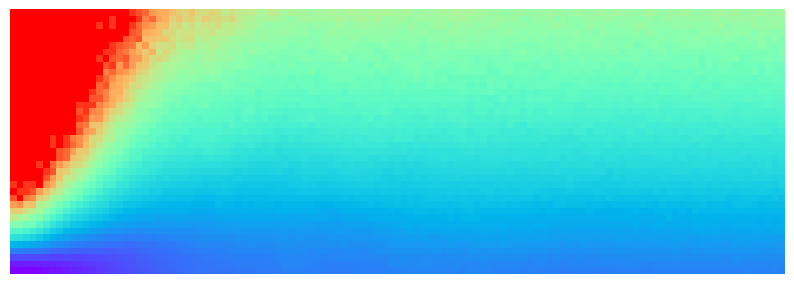

In [191]:
learn.activation_stats.color_dim(-4)

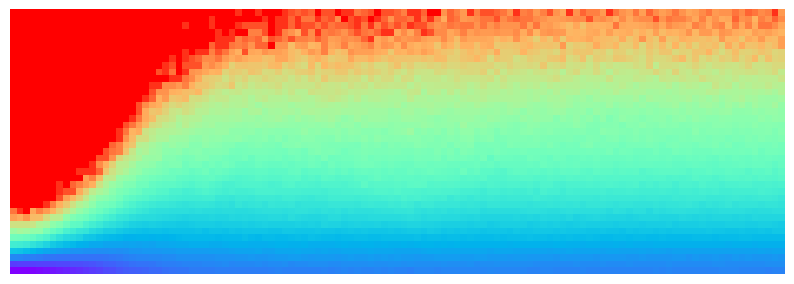

In [194]:
learn.activation_stats.color_dim(-4)

In [195]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.188402,0.096878,0.970400,00:06
1,0.084539,0.084810,0.974000,00:06
2,0.054126,0.039056,0.988800,00:06
3,0.034422,0.031917,0.989100,00:06
4,0.018799,0.023247,0.993300,00:06


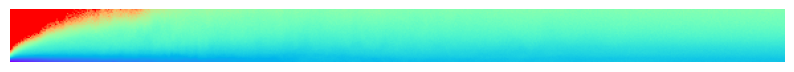

In [196]:
learn.activation_stats.color_dim(-4)

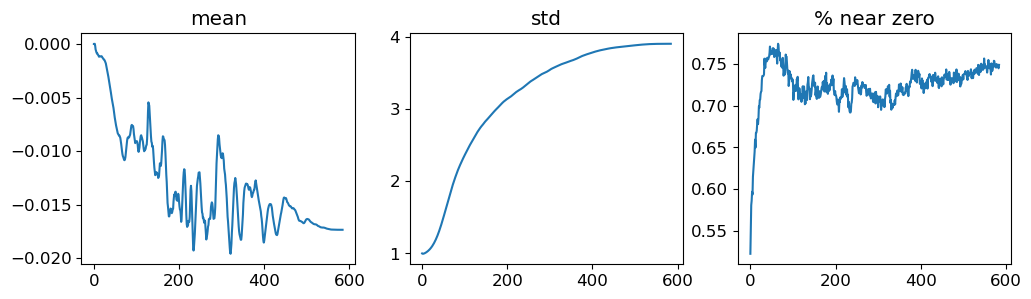

In [197]:
learn.activation_stats.plot_layer_stats(-1)